# Graphs

This section contains the application of the gosduma7 dataset to recreate graphs found elsewhere.

## Recreating the Graph from [Slon.ru](https://tjournal.ru/34502-zhurnalisti-slonru-matematicheski-obnaruzhili-priznaki-masshtabnih-falsifikacii-na-viborah-v-gosdumu)
The X-axis shows the percentage of votes gained, from 0.00 to 1.00. The Y-axis shows the total votes for that party across all polling stations with the specified percentage of votes for a particular party.

In [1]:
# Some initialization magic
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import collections

# Let's load up the data
import json

with open("scrapyproject/results.json") as fin:
    tables = [json.loads(line) for line in fin]

In [2]:
FEDERAL_HEADERS = [t for t in tables if t["data_type"] == "federal"][0]["row_headers"]
FEDERAL_HEADERS

['Число избирателей, внесенных в список избирателей на момент окончания голосования',
 'Число избирательных бюллетеней, полученных участковой избирательной комиссией',
 'Число избирательных бюллетеней, выданных избирателям, проголосовавшим досрочно',
 'Число избирательных бюллетеней, выданных в помещении для голосования в день голосования',
 'Число избирательных бюллетеней, выданных вне помещения для голосования в день голосования',
 'Число погашенных избирательных бюллетеней',
 'Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования',
 'Число избирательных бюллетеней, содержащихся в стационарных ящиках для голосования',
 'Число недействительных избирательных бюллетеней',
 'Число действительных избирательных бюллетеней',
 'Число открепительных удостоверений, полученных участковой избирательной комиссией',
 'Число открепительных удостоверений, выданных на избирательном участке до дня голосования',
 'Число избирателей, проголосовавших по открепительным удостовер

In [3]:
a_table = [t for t in tables if t["data_type"] == "federal"][0]
PARTY_IDX, PARTIES = zip(*[(i, j) for (i, j) in enumerate(a_table["row_headers"]) if i >= 18])
PARTIES

('1. ВСЕРОССИЙСКАЯ ПОЛИТИЧЕСКАЯ ПАРТИЯ "РОДИНА"',
 '2. Политическая партия КОММУНИСТИЧЕСКАЯ ПАРТИЯ КОММУНИСТЫ РОССИИ',
 '3. Политическая партия "Российская партия пенсионеров за справедливость"',
 '4. Всероссийская политическая партия "ЕДИНАЯ РОССИЯ"',
 '5. Политическая партия "Российская экологическая партия "Зеленые"',
 '6. Политическая партия "Гражданская Платформа"',
 '7. Политическая партия ЛДПР - Либерально-демократическая партия России',
 '8. Политическая партия "Партия народной свободы" (ПАРНАС)',
 '9. Всероссийская политическая партия "ПАРТИЯ РОСТА"',
 '10. Общественная организация Всероссийская политическая партия "Гражданская Сила"',
 '11. Политическая партия "Российская объединенная демократическая партия "ЯБЛОКО"',
 '12. Политическая партия "КОММУНИСТИЧЕСКАЯ ПАРТИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ"',
 '13. Политическая партия "ПАТРИОТЫ РОССИИ"',
 '14. Политическая партия СПРАВЕДЛИВАЯ РОССИЯ')

In [4]:
import scipy.signal


def station_generator(selected_tables=tables):
    """Yield the polling stations (UIK) along with the attributes that we will be plotting."""
    for table in [t for t in selected_tables if t["data_type"] == "federal_uik"]:
        eligible_voters_idx = FEDERAL_HEADERS.index('Число избирателей, внесенных в список избирателей на момент окончания голосования')
        eligible_voters = table["data"][eligible_voters_idx]

        valid_ballots_idx = FEDERAL_HEADERS.index('Число действительных избирательных бюллетеней')
        valid_ballots = table["data"][valid_ballots_idx]

        # Calculate the turnout as the number of valid ballots out of the total number of voters for that station
        # One-based indexing because the first column is the total across all stations.
        #
        # The votes array for each station contain the number of votes counted for each party, in order of PARTIES.
        # The fraction array contains the proportion of votes for each party, in the same order.
        for st_idx, st_name in enumerate(table["column_headers"]):
            if st_idx == 0:
                # skip the total across all stations
                continue
            station = {
                "region": table["region"],
                "area_ik": table["area_ik"],
                "local_ik": st_name,
                "fraction": [],
                "votes": [],
                "turnout": valid_ballots[st_idx] / eligible_voters[st_idx]
            }
            for party_idx in PARTY_IDX:
                raw_votes = table["data"][party_idx][st_idx]
                station["votes"].append(raw_votes)
                station["fraction"].append(raw_votes / valid_ballots[st_idx])

            yield station

        
def round_nearest(x, a=0.002):
    """Round the x-value to the nearest a-value."""
    # http://stackoverflow.com/questions/28425705/python-rounding-a-floating-point-number-to-nearest-0-05
    return round(x / a) * a


def bin_by(stations, key_function, round_function=round_nearest):
    """Bin each polling station by the turnout at the station."""
    bins = collections.defaultdict(list)
    for station in stations:
        bins[round_function(key_function(station))].append(station)
    return sorted(bins.items())


def box_filter(y, box_pts=7):
    """Smoooth the y-signal using a regular box filter of the specified width."""
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

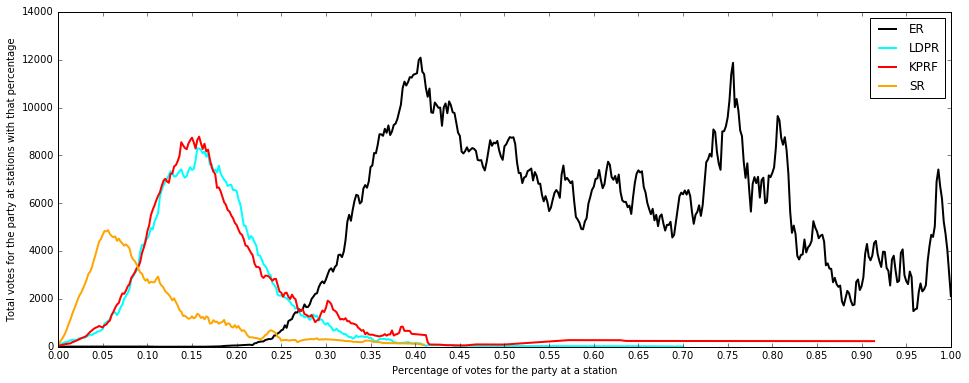

In [5]:
def plot(full_party_name, ascii_name, color, linewidth=2, data_type="federal"):
    stations = list(station_generator())
    assert stations
        
    party_idx = PARTIES.index(full_party_name)
    bins = bin_by(stations, lambda station: station["fraction"][party_idx])
    
    x = [val for (val, _) in bins]
    y = [sum(st["votes"][party_idx] for st in stations) for (_, stations) in bins]
    #
    # the graph isn't really viewable without smoothing
    #
    y = box_filter(y)
    
    plt.plot(x, y, linewidth=linewidth, label=ascii_name, color=color)

plt.figure(figsize=(16, 6))

plot('4. Всероссийская политическая партия "ЕДИНАЯ РОССИЯ"', "ER", "black")
plot('7. Политическая партия ЛДПР - Либерально-демократическая партия России', "LDPR", "cyan")
plot('12. Политическая партия "КОММУНИСТИЧЕСКАЯ ПАРТИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ"', "KPRF", "red")
plot('14. Политическая партия СПРАВЕДЛИВАЯ РОССИЯ', "SR", "orange")

plt.xticks(np.arange(0, 1.05, 0.05))
plt.ylabel("Total votes for the party at stations with that percentage")
plt.xlabel("Percentage of votes for the party at a station")

plt.legend()

print()

## The Voter Turnout Graph
The X-axis shows the turnout percentage, calculated as the number of valid ballots divided by the total number of eligible voters. The Y-axis shows the total number of votes for each party for each polling station with the specified turnout.

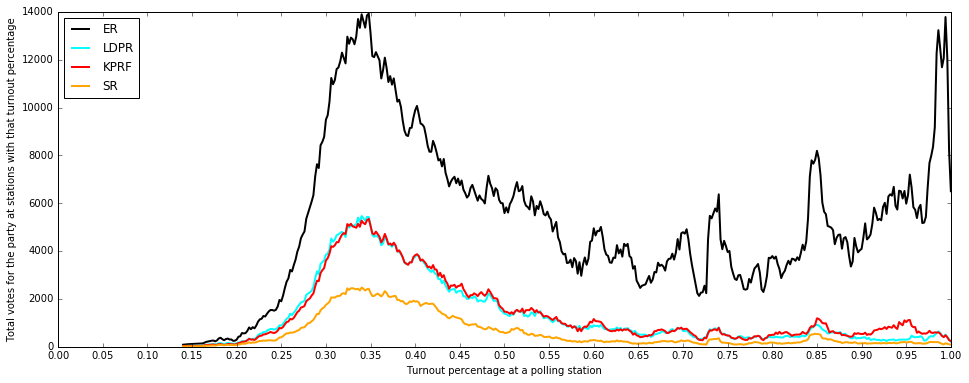

In [6]:
def plot(full_party_name, ascii_name, color, linewidth=2):
    stations = list(station_generator())
        
    assert stations
        
    party_idx = PARTIES.index(full_party_name)
    bins = bin_by(stations, lambda station: station["turnout"])
    
    x = [val for (val, _) in bins]
    y = [sum(st["votes"][party_idx] for st in stations) for (_, stations) in bins]
    y = box_filter(y)
    
    plt.plot(x, y, linewidth=linewidth, label=ascii_name, color=color)


plt.figure(figsize=(16, 6))

plot('4. Всероссийская политическая партия "ЕДИНАЯ РОССИЯ"', "ER", "black")
plot('7. Политическая партия ЛДПР - Либерально-демократическая партия России', "LDPR", "cyan")
plot('12. Политическая партия "КОММУНИСТИЧЕСКАЯ ПАРТИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ"', "KPRF", "red")
plot('14. Политическая партия СПРАВЕДЛИВАЯ РОССИЯ', "SR", "orange")

plt.xticks(np.arange(0, 1.05, 0.05))
plt.ylabel("Total votes for the party at stations with that turnout percentage")
plt.xlabel("Turnout percentage at a polling station")

plt.legend(loc="upper left")

print()

# The Recurring Figure of 62%

[Link](http://www.rbc.ru/rbcfreenews/57e37f639a7947074b469638?from=main) to slon.ru article.

In [7]:
stations = list(station_generator())
er_idx = PARTIES.index('4. Всероссийская политическая партия "ЕДИНАЯ РОССИЯ"')
counter = collections.Counter(sorted([round(st["fraction"][er_idx] * 100) for st in stations]))
counter.most_common(5)

[(39, 248), (40, 240), (41, 232), (44, 224), (42, 223)]

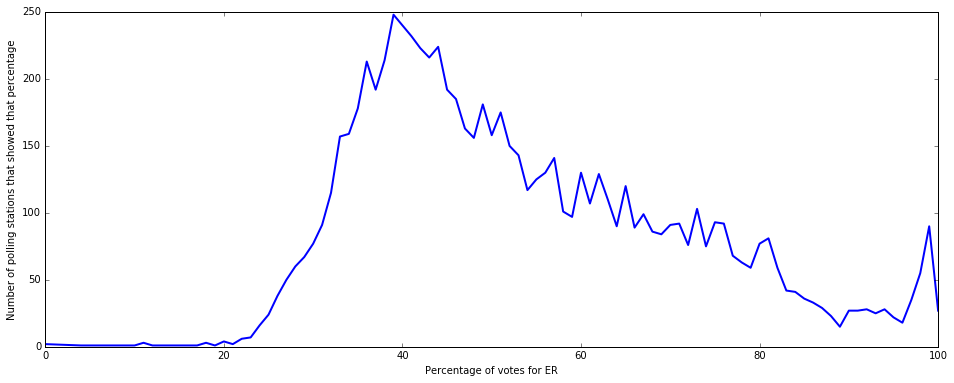

In [8]:
plt.figure(figsize=(16, 6))
x, y = zip(*list(counter.items()))
plt.plot(x, y, linewidth=2)
plt.xlabel("Percentage of votes for ER")
plt.ylabel("Number of polling stations that showed that percentage")
print()

## ... and in Saratov Oblast

In [9]:
saratov = [t for t in tables if t["data_type"] == "federal_uik" and "саратов" in t["region"].lower()]
assert saratov
saratov_stations = list(station_generator(saratov))
counter = collections.Counter(sorted([round(st["fraction"][er_idx] * 100) for st in saratov_stations]))
counter.most_common(5)

[(81, 18), (80, 12), (40, 8), (44, 8), (45, 8)]

In [10]:
len(saratov_stations)

187

In [11]:
[(t["region"], t["area_ik"], len(t["column_headers"][1:])) for t in saratov]

[('Саратовская область', 'ОИК №165', 32),
 ('Саратовская область', 'ОИК №164', 103),
 ('Саратовская область', 'ОИК №163', 30),
 ('Саратовская область', 'ОИК №166', 22)]